In [1]:
import numpy as np, matplotlib.pyplot as plt, pandas as pd
pd.set_option('display.max_rows', 50)

import os
# Use this to see how much memory the dataframes use
from sys import getsizeof

import yaml

import pseudopeople as pp
from pseudopeople.configuration import get_configuration
from vivarium.framework.randomness import RandomnessStream
from vivarium.config_tree import ConfigTree

from vivarium_research_prl.utils import sizemb, MappingViaAttributes
from vivarium_research_prl import datatypes
from vivarium_research_prl.noise import corruption, fake_names, noisify
from vivarium_research_prl.find_kids import datasets, noisify_data
from vivarium_research_prl import alpha

!date
!whoami
!uname -a
!pwd

Fri 14 Apr 2023 11:24:36 PM PDT
ndbs
Linux long-slurm-sarchive-p0041 5.4.0-135-generic #152-Ubuntu SMP Wed Nov 23 20:19:22 UTC 2022 x86_64 x86_64 x86_64 GNU/Linux
/mnt/share/code/ndbs/vivarium_research_prl/pseudopeople_testing


# Data!

```
/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/
```

In [2]:
project_dir = '/mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop'
model_dir = (
    f'{project_dir}/results'
    '/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04'
)
parquet_dir = f'{model_dir}/final_results/parquet'
hdf_dir = f'{model_dir}/final_results/hdf'
rhode_island_par_dir = f'{parquet_dir}/states/rhode_island'
usa_par_dir = f'{parquet_dir}/usa'
rhode_island_hdf_dir = f'{hdf_dir}/states/rhode_island'
usa_hdf_dir = f'{hdf_dir}/usa'

!ls -halt $parquet_dir

total 96K
drwxrwsr-x  3 rmudambi IHME-Simulationscience  512 Apr  9 18:48 states
drwxrwsr-x  5 rmudambi IHME-Simulationscience 1.5K Apr  9 18:48 .
drwxrwsr-x 10 rmudambi IHME-Simulationscience 4.0K Apr  9 15:41 usa
drwxrwsr-x  4 rmudambi IHME-Simulationscience 2.0K Apr  9 15:21 ..
drwxrwsr-x  2 rmudambi IHME-Simulationscience 336K Apr  9 12:05 logs


In [3]:
!ls -halt $usa_par_dir

total 284K
drwxrwsr-x  5 rmudambi IHME-Simulationscience 1.5K Apr  9 18:48 ..
drwxrwsr-x 10 rmudambi IHME-Simulationscience 4.0K Apr  9 15:41 .
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  9 12:21 tax_dependents_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  9 12:20 tax_1040_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  9 12:15 tax_w2_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  9 12:09 social_security_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  9 12:09 wic_observer
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  9 12:09 household_survey_observer_cps
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  9 12:09 household_survey_observer_acs
drwxrwsr-x  2 rmudambi IHME-Simulationscience 167K Apr  9 12:09 decennial_census_observer


# Load the full USA decennial census from 2020!

I've got 500 GB of RAM and 7 days of cluster time. Based on the Rhode Island data, I estimate the USA census should take under 250 GB of RAM and 67 hours. Let's hope!

Holy crap, it only took 1h 32min 16s!!!

And it takes up 223.275 GB.

In [4]:
%%time
df_census = pp.generate_decennial_census(usa_par_dir, verbose=True)
df_census

2023-04-14 23:34:19.537 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9696.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:34:35.697 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9024.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:34:51.752 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3240.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-14 23:35:07.905 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1490.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:35:23.817 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6203.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.08s/type]


2023-04-14 23:35:39.722 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5475.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.08s/type]


2023-04-14 23:35:55.615 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5072.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:36:11.477 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9526.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:36:27.514 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1935.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:36:43.342 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5399.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:36:59.338 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3731.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:37:15.208 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3380.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:37:31.081 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3326.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:37:47.088 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_558.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:38:03.074 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_440.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:38:19.110 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9577.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-14 23:38:35.207 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3465.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:38:51.156 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7530.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:39:07.001 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_40.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:39:22.961 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5300.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-14 23:39:39.147 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4621.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:39:54.921 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3545.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:40:10.772 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_656.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:40:26.753 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7264.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:40:42.726 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3713.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:40:58.647 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5703.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:41:14.476 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6975.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:41:30.522 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_352.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:41:46.559 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5594.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:42:02.343 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2405.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:42:18.316 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1483.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:42:34.120 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1219.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:42:50.007 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5901.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.08s/type]


2023-04-14 23:43:05.812 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9225.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:43:21.745 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6817.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:43:37.480 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2721.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-14 23:43:53.613 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7384.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:44:09.434 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4123.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:44:25.262 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_496.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:44:40.996 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2298.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:44:56.941 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9643.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:45:12.752 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7107.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:45:28.712 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9872.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:45:44.650 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4950.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:46:00.620 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8156.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:46:16.504 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1299.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:46:32.254 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4649.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:46:48.024 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_778.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:47:03.802 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8305.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:47:19.646 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3202.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:47:35.620 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1667.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:47:51.472 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8612.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:48:07.329 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4904.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:48:23.343 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3225.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:48:39.134 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5159.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:48:54.960 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2689.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:49:10.757 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9859.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-14 23:49:26.869 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8129.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:49:42.778 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9284.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:49:58.687 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3528.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:50:14.555 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5398.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:50:30.645 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_682.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.08s/type]


2023-04-14 23:50:46.396 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3994.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:51:02.341 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1182.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:51:18.251 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6982.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:51:34.273 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3568.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:51:50.130 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1232.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:52:05.986 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6778.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:52:21.993 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2599.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:52:37.948 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6539.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:52:53.916 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_323.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:53:09.896 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_465.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:53:25.789 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3254.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.13s/type]


2023-04-14 23:53:42.017 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5619.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:53:57.952 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9740.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:54:13.865 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9840.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:54:29.750 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1154.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:54:45.816 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3624.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:55:01.708 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3066.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:55:17.593 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3454.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:55:33.435 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5950.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:55:49.394 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9901.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:56:05.421 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9804.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:56:21.257 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1356.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:56:37.062 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6554.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:56:53.034 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3825.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:57:09.066 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8869.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:57:25.276 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2461.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:57:41.323 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4637.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:57:57.396 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3684.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:58:13.327 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5439.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:58:29.207 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6751.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-14 23:58:45.055 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5781.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:59:00.903 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7551.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:59:16.875 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7054.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-14 23:59:32.797 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1614.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-14 23:59:48.795 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7137.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:00:04.732 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6191.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:00:20.759 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5685.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:00:36.640 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5004.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:00:52.596 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4192.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:01:08.635 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5860.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:01:24.648 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3938.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:01:40.629 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3984.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:01:56.557 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_734.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:02:12.426 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_781.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:02:28.453 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8516.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:02:44.453 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9159.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:03:00.211 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9292.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:03:16.059 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3585.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:03:31.923 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9495.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:03:47.988 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9244.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:04:03.875 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6545.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:04:19.815 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6874.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:04:35.781 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2700.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:04:51.749 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8134.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:05:07.623 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9066.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:05:23.506 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6606.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:05:39.482 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3305.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:05:55.320 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1559.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.13s/type]


2023-04-15 00:06:11.541 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1200.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:06:27.549 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9971.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:06:43.640 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5812.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:06:59.535 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3947.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:07:15.539 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1177.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:07:31.590 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8192.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:07:47.467 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1452.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:08:03.547 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1832.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:08:19.498 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8509.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:08:35.527 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3776.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:08:51.416 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5892.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:09:07.260 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5114.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:09:23.263 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8360.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:09:39.270 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9723.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:09:55.147 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7292.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:10:11.194 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1917.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:10:27.172 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_494.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:10:43.162 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9434.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:10:59.084 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3723.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:11:15.104 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5949.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:11:31.245 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7179.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:11:47.325 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4941.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:12:03.211 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2863.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:12:19.242 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1534.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:12:35.115 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3541.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:12:51.085 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3298.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:13:07.065 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7125.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:13:23.083 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3304.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:13:39.039 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6144.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:13:54.971 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5831.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:14:11.029 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2277.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:14:27.063 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_386.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:14:42.918 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9367.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:14:58.867 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9402.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:15:14.929 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7850.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:15:30.965 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2054.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:15:46.917 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2229.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:16:02.965 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2965.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:16:19.097 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5863.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:16:35.211 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8527.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:16:51.204 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_28.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:17:07.280 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7086.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:17:23.229 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9247.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:17:39.148 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8425.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:17:55.084 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5548.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:18:11.099 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6118.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:18:26.912 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2989.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:18:42.827 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4369.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:18:58.808 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1597.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:19:14.776 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7016.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:19:30.677 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_771.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:19:46.720 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4938.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:20:02.768 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5348.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:20:18.672 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5616.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:20:34.443 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1235.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:20:50.444 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4344.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:21:06.416 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_446.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:21:22.353 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5797.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:21:38.286 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7359.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:21:54.407 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1069.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:22:10.419 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7870.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:22:26.449 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4922.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:22:42.595 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9653.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:22:58.596 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_432.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:23:14.589 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7985.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:23:30.579 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6079.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:23:46.669 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4400.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:24:02.419 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7594.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:24:18.479 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8877.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:24:34.531 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4943.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:24:50.596 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4528.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:25:06.559 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5501.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:25:22.458 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6701.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:25:38.587 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6123.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:25:54.535 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1990.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:26:10.447 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_315.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:26:26.499 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1007.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:26:42.630 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6090.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:26:58.624 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1074.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:27:14.825 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3481.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.15s/type]


2023-04-15 00:27:31.188 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9187.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:27:47.173 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8734.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:28:03.125 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3632.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:28:19.293 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4255.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:28:35.248 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7745.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:28:51.159 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6790.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:29:07.198 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7938.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:29:23.222 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3142.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:29:39.199 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5393.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:29:55.436 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2047.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:30:11.575 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4507.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:30:27.617 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6442.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:30:43.536 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4202.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:30:59.668 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8997.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:31:15.645 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_860.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:31:31.647 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4496.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:31:47.690 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9888.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:32:03.792 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_131.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:32:19.727 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_107.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:32:35.579 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1933.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:32:51.589 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3374.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:33:07.509 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5698.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:33:23.483 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2787.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:33:39.517 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1753.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:33:55.550 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6760.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:34:11.546 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6793.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:34:27.651 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1897.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:34:43.697 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3591.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:34:59.717 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1632.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:35:15.743 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5246.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:35:31.779 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8838.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:35:47.679 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6654.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:36:03.660 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8755.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:36:19.730 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9588.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:36:35.877 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8133.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:36:51.901 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6800.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:37:07.870 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8501.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:37:23.909 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3167.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:37:40.059 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7927.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:37:56.003 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4260.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:38:11.993 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4802.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:38:27.936 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6519.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:38:43.993 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_338.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:39:00.065 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3093.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.09s/type]


2023-04-15 00:39:15.977 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_103.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:39:32.105 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6455.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:39:48.078 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9911.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:40:04.092 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7438.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:40:20.205 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2284.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:40:36.333 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9272.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:40:52.339 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8628.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:41:08.362 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1508.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:41:24.499 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6520.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:41:40.489 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5188.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:41:56.461 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3377.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:42:12.462 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_974.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:42:28.565 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2311.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:42:44.520 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_278.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:43:00.642 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_821.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:43:16.681 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1562.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:43:32.750 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2476.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:43:48.874 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7645.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:44:04.990 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5969.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:44:21.006 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1648.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:44:37.209 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6207.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:44:53.282 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1655.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.13s/type]


2023-04-15 00:45:09.385 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2477.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:45:25.481 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5046.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:45:41.422 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6991.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:45:57.419 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4672.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:46:13.387 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4203.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:46:29.485 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9847.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:46:45.415 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9871.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:47:01.468 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7164.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:47:17.616 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1061.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:47:33.675 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3586.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:47:49.698 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9549.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:48:05.903 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1777.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:48:21.862 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1091.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:48:37.961 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7275.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:48:53.947 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4743.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:49:10.024 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3621.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:49:26.051 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1282.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:49:42.298 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8221.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:49:58.516 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6324.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:50:14.670 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1362.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:50:30.836 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7344.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:50:46.928 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3357.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:51:02.978 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2448.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:51:19.218 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1482.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:51:35.296 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9776.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:51:51.313 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3390.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:52:07.506 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6810.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:52:23.691 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8641.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:52:39.712 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7817.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:52:55.858 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2500.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:53:11.880 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8291.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:53:27.839 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_93.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:53:43.904 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3793.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:54:00.152 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4622.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:54:16.186 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5440.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:54:32.217 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_1609.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:54:48.369 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2416.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 00:55:04.307 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3725.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:55:20.430 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7589.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:55:36.558 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_4561.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:55:52.573 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5875.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/type]


2023-04-15 00:56:08.929 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_539.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:56:24.894 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8817.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:56:40.875 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9772.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:56:56.996 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3607.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:57:13.047 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7653.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:57:29.132 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5150.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:57:45.310 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_99.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:58:01.369 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7342.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:58:17.393 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5670.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:58:33.508 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3598.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:58:49.721 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7511.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:59:05.831 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3789.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.17s/type]


2023-04-15 00:59:22.422 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6007.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 00:59:38.516 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_478.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.12s/type]


2023-04-15 00:59:54.718 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5628.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.18s/type]


2023-04-15 01:00:11.337 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9768.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 01:00:27.491 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6487.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 01:00:43.565 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5020.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 01:00:59.753 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_9672.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 01:01:15.848 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_2808.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 01:01:31.838 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6776.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.13s/type]


2023-04-15 01:01:48.125 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_6929.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 01:02:04.258 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_8980.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 01:02:20.293 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_7303.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:09<00:00,  1.14s/type]


2023-04-15 01:02:36.610 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3595.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


2023-04-15 01:02:52.525 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_3978.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.11s/type]


2023-04-15 01:03:08.520 | pseudopeople.interface:_generate_form:68 - Loading data from /mnt/team/simulation_science/priv/engineering/vivarium_census_prl_synth_pop/results/v2.0_three_censuses/united_states_of_america/2023_04_08_14_07_04/final_results/parquet/usa/decennial_census_observer/decennial_census_observer_5308.parquet.


Applying noise: 100%|███████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.10s/type]


CPU times: user 1h 27min 16s, sys: 6min 4s, total: 1h 33min 21s
Wall time: 1h 32min 16s


,simulant_id,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,relation_to_household_head,sex,race_ethnicity
0,9696_0,Roberto,J,Kinder,37,11/10/1982,7365,sioux street,,mary esther,FL,33404,Reference person,Male,White
1,9696_1,Sabrina,K,Kinder,36,03/10/1984,810,dungeness ct,no 1,grafton,MA,01527,Other nonrelative,Female,White
2,9696_2,Raylan,J,Kinder,2,03/31/2017,7365,sioux street,,mary esther,FL,33404,Biological child,Male,White
3,9696_3,Ryan,J,Fors,26,07/21/1993,1110,hershey ln,,aurora,IL,62220,Reference person,Male,White
4,9696_4,Sabrina,K,Timmons,23,03/28/1996,1110,hershey ln,,aurora,IL,62220,Other nonrelative,Female,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332163845,5308_1022995,Kyle,J,Valdez,28,10/22/1991,135,port elissa lndg,,allen,TX,76119,Opp-sex spouse,Male,Latino
332163846,5308_1022996,Grace,C,Valdez,8,12/24/2011,135,port elissa lndg,,allen,TX,76119,Institutionalized GQ pop,Female,Latino
332163847,5308_1022997,Brandon,G,Valdez,6,04/14/2014,135,port elissa lndg,,allen,TX,76119,Biological child,Male,Latino
332163848,5308_1022998,Veronica,A,Valdez,3,02/07/2017,135,port elissa lndg,,allen,TX,76119,Biological child,Female,Latino


# See how big the data is

In [5]:
%%time
sizemb(df_census)

CPU times: user 6min 29s, sys: 16.7 s, total: 6min 46s
Wall time: 6min 44s


223275.035997

# Time some simple operations on columns

In [6]:
%%time
df_census.unit_number.isna().sum()

CPU times: user 13.4 s, sys: 652 ms, total: 14.1 s
Wall time: 14 s


187049

In [7]:
%%time
(df_census.unit_number == '').sum()

CPU times: user 15.1 s, sys: 169 ms, total: 15.3 s
Wall time: 15.2 s


313513686

# Check dtypes and test converting to categorical

In [8]:
df_census.dtypes

simulant_id                     object
first_name                      object
middle_initial                  object
last_name                       object
age                             object
date_of_birth                   object
street_number                   object
street_name                     object
unit_number                     object
city                            object
state                         category
zipcode                         object
relation_to_household_head    category
sex                           category
race_ethnicity                category
dtype: object

In [10]:
%%time
temp = df_census.iloc[:1000].copy()
temp

CPU times: user 7.45 ms, sys: 0 ns, total: 7.45 ms
Wall time: 6.91 ms


,simulant_id,first_name,middle_initial,last_name,age,date_of_birth,street_number,street_name,unit_number,city,state,zipcode,relation_to_household_head,sex,race_ethnicity
0,9696_0,Roberto,J,Kinder,37,11/10/1982,7365,sioux street,,mary esther,FL,33404,Reference person,Male,White
1,9696_1,Sabrina,K,Kinder,36,03/10/1984,810,dungeness ct,no 1,grafton,MA,01527,Other nonrelative,Female,White
2,9696_2,Raylan,J,Kinder,2,03/31/2017,7365,sioux street,,mary esther,FL,33404,Biological child,Male,White
3,9696_3,Ryan,J,Fors,26,07/21/1993,1110,hershey ln,,aurora,IL,62220,Reference person,Male,White
4,9696_4,Sabrina,K,Timmons,23,03/28/1996,1110,hershey ln,,aurora,IL,62220,Other nonrelative,Female,White
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,9696_1022,David,J,Cox,64,04/10/1955,819,canterbury hill rd,,sylvania,OH,44145,Reference person,Male,White
996,9696_1023,Charles,J,Cox,29,11/07/1990,819,canterbury hill rd,,sylvania,OH,44145,Biological child,Male,White
997,9696_1024,John,P,Malikowski,53,04/16/1966,18,selma street,,visalia,CA,92647,Reference person,Male,White
998,9696_1025,Connie,K,Malikowski,53,11/08/1966,18,selma street,,visalia,CA,92647,Opp-sex spouse,Female,White


In [14]:
%%time
with pd.option_context("mode.copy_on_write", True):
    temp = df_census.iloc[:1000] # Without copy-on-write enabled, I should make a copy here instead
    datatypes.convert_dtypes(temp)
temp.dtypes

CPU times: user 16.3 ms, sys: 16 µs, total: 16.3 ms
Wall time: 14.8 ms


simulant_id                     object
first_name                    category
middle_initial                category
last_name                     category
age                            float32
date_of_birth                 category
street_number                 category
street_name                   category
unit_number                   category
city                          category
state                         category
zipcode                       category
relation_to_household_head    category
sex                           category
race_ethnicity                category
dtype: object

In [15]:
%%time
with pd.option_context("mode.copy_on_write", True):
    datatypes.convert_string_ids_to_ints(temp)
temp.dtypes

CPU times: user 7.83 ms, sys: 0 ns, total: 7.83 ms
Wall time: 7.6 ms


simulant_id                      int64
first_name                    category
middle_initial                category
last_name                     category
age                            float32
date_of_birth                 category
street_number                 category
street_name                   category
unit_number                   category
city                          category
state                         category
zipcode                       category
relation_to_household_head    category
sex                           category
race_ethnicity                category
dtype: object

# Look at distribution of relation to household head

In [16]:
%%time
relation_counts = df_census.relation_to_household_head.value_counts()
relation_counts

CPU times: user 1.22 s, sys: 706 ms, total: 1.93 s
Wall time: 1.92 s


Reference person               130747185
Biological child                79841288
Opp-sex spouse                  51974260
Other nonrelative               13660258
Grandchild                       7642143
Noninstitutionalized GQ pop      6672826
Opp-sex partner                  6563977
Institutionalized GQ pop         6378938
Other relative                   4753405
Roommate                         4559494
Sibling                          3597210
Stepchild                        3377270
Parent                           3294325
Adopted child                    1985308
Child-in-law                     1263013
Parent-in-law                     959144
Same-sex spouse                   694310
Same-sex partner                  534371
Foster child                      425413
Name: relation_to_household_head, dtype: int64

<AxesSubplot: >

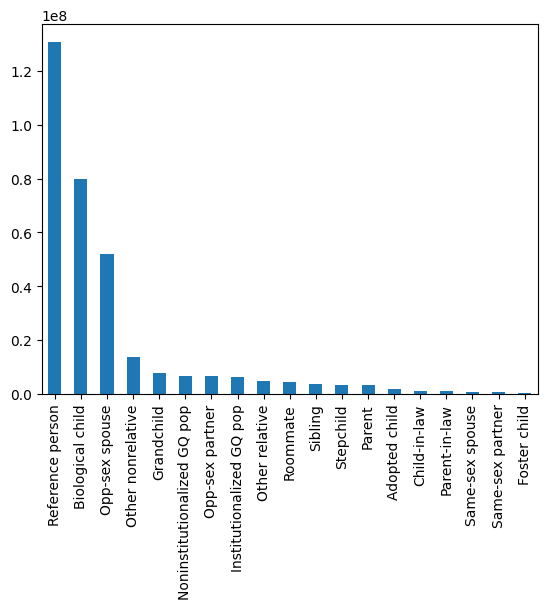

In [17]:
relation_counts.plot.bar()

# Look at age distribution

In [20]:
%%time
age_counts = df_census.age.astype(str).value_counts()
age_counts

CPU times: user 1min 11s, sys: 15.4 s, total: 1min 27s
Wall time: 1min 26s


31      4443227
30      4425058
32      4419866
19      4397633
29      4397120
         ...   
5426          1
4758          1
4875          1
4541          1
945           1
Name: age, Length: 887, dtype: int64

In [21]:
age_counts.sort_index()

0      3867334
00        1446
001          3
002          5
01        1532
        ...   
99        7920
995          5
996          6
998          1
nan    3336683
Name: age, Length: 887, dtype: int64

In [34]:
age_counts_ordered = age_counts.sort_index()
age_counts_clean = (
    age_counts_ordered
    .loc[age_counts_oredered > 10_000]
    .drop('nan')
)
age_counts_clean = age_counts_clean.set_axis(age_counts_clean.index.astype(int)).sort_index()
age_counts_clean

0     3867334
1     4192462
2     3189699
3     3658641
4     3814819
       ...   
94     351456
95     433018
96     341012
97     169691
98      47057
Name: age, Length: 99, dtype: int64

<AxesSubplot: >

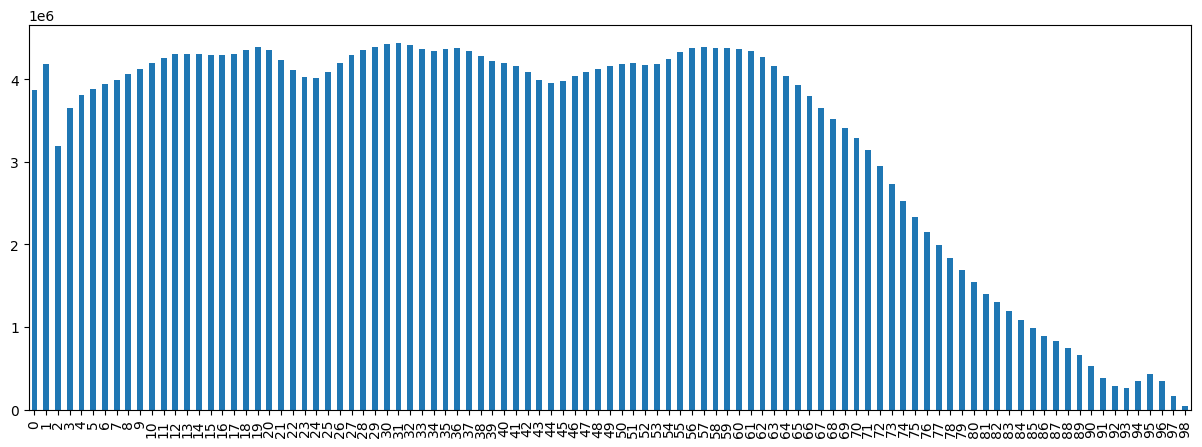

In [36]:
fig, ax = plt.subplots(figsize=(15,5))
age_counts_clean.plot.bar(ax=ax)

## Looks like we still have mixed datatypes for age -- int and str (plus float for NaN)

In [41]:
%%time
df_census.age.map(type).value_counts()

CPU times: user 30.7 s, sys: 4.38 s, total: 35.1 s
Wall time: 34.9 s


<class 'int'>      325602608
<class 'float'>      3336683
<class 'str'>        3224559
Name: age, dtype: int64

# Look at state distribution

In [38]:
%%time
state_counts = df_census.state.value_counts()
state_counts

CPU times: user 1.19 s, sys: 690 ms, total: 1.88 s
Wall time: 1.87 s


CA    38481197
TX    28394050
FL    20564128
NY    19882629
PA    13146704
        ...   
ND      856531
AK      760274
DC      688066
VT      679450
WY      669334
Name: state, Length: 51, dtype: int64

<AxesSubplot: >

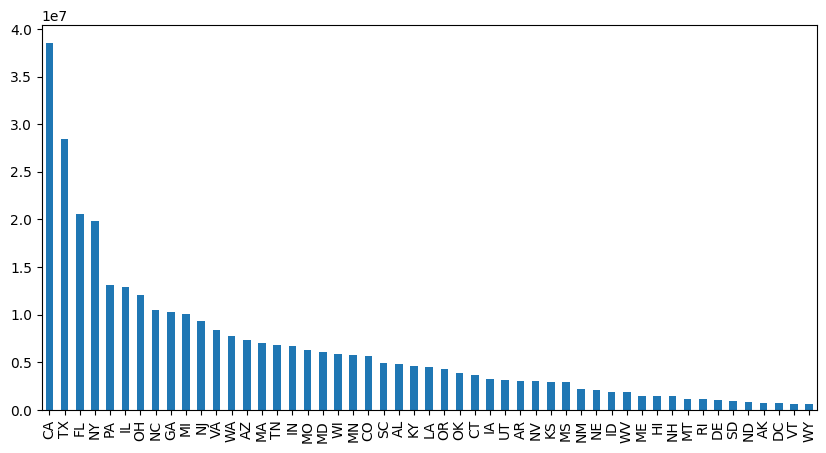

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
state_counts.plot.bar(ax=ax)

# Test converting dtypes again

In [42]:
%%time
with pd.option_context("mode.copy_on_write", True):
    temp = df_census.iloc[:1000] # Without copy-on-write enabled, I should make a copy here instead
    datatypes.convert_dtypes(temp)
temp.dtypes

CPU times: user 14.4 ms, sys: 3.9 ms, total: 18.3 ms
Wall time: 17.2 ms


simulant_id                     object
first_name                    category
middle_initial                category
last_name                     category
age                            float32
date_of_birth                 category
street_number                 category
street_name                   category
unit_number                   category
city                          category
state                         category
zipcode                       category
relation_to_household_head    category
sex                           category
race_ethnicity                category
dtype: object

In [48]:
def convert_to_int_and_categorical(df):
    datatypes.convert_string_ids_to_ints(df)
    for col, dtype in df.dtypes.items():
        if dtype == 'object':
            df[col] = df[col].astype('category')

with pd.option_context("mode.copy_on_write", True):
    temp = df_census.iloc[:1_000] # Without copy-on-write enabled, I should make a copy here instead
    print(sizemb(temp))
    convert_to_int_and_categorical(temp)
print(sizemb(temp))
temp.dtypes

0.677045
0.394546


simulant_id                      int64
first_name                    category
middle_initial                category
last_name                     category
age                           category
date_of_birth                 category
street_number                 category
street_name                   category
unit_number                   category
city                          category
state                         category
zipcode                       category
relation_to_household_head    category
sex                           category
race_ethnicity                category
dtype: object

In [50]:
%%time
with pd.option_context("mode.copy_on_write", True):
    temp = df_census.iloc[:1_000_000] # Without copy-on-write enabled, I should make a copy here instead
    print(sizemb(temp))
    convert_to_int_and_categorical(temp)
print(sizemb(temp))
temp.dtypes

672.424413
87.728014
CPU times: user 5.57 s, sys: 292 ms, total: 5.86 s
Wall time: 5.86 s


simulant_id                      int64
first_name                    category
middle_initial                category
last_name                     category
age                           category
date_of_birth                 category
street_number                 category
street_name                   category
unit_number                   category
city                          category
state                         category
zipcode                       category
relation_to_household_head    category
sex                           category
race_ethnicity                category
dtype: object

In [51]:
temp.age

0         37
1         36
2          2
3         26
4         23
          ..
999995    43
999996    41
999997    26
999998    40
999999    44
Name: age, Length: 1000000, dtype: category
Categories (352, object): [0, 1, 2, 3, ..., '969', '97', '98', '99']

In [52]:
temp.date_of_birth

0         11/10/1982
1         03/10/1984
2         03/31/2017
3         07/21/1993
4         03/28/1996
             ...    
999995    09/05/1976
999996    09/21/1978
999997    07/18/1993
999998    11/15/1979
999999    05/03/1975
Name: date_of_birth, Length: 1000000, dtype: category
Categories (42862, object): ['00/01/1939', '00/02/1935', '00/03/1934', '00/03/2054', ..., '99/17/1969', '99/19/1934', '99/20/1751', '99/26/1978']

In [53]:
6*334/60

33.4

# Check the size of each zipcode

In [54]:
%%time
zipcode_sizes = df_census.groupby('zipcode')['simulant_id'].nunique().sort_values()
zipcode_sizes

CPU times: user 5min 4s, sys: 1min 38s, total: 6min 43s
Wall time: 6min 42s


zipcode
00000          1
481174         1
481163         1
481158         1
481152         1
           ...  
77084     108318
11207     112397
77449     113713
10467     115515
75034     130759
Name: simulant_id, Length: 221149, dtype: int64

<AxesSubplot: >

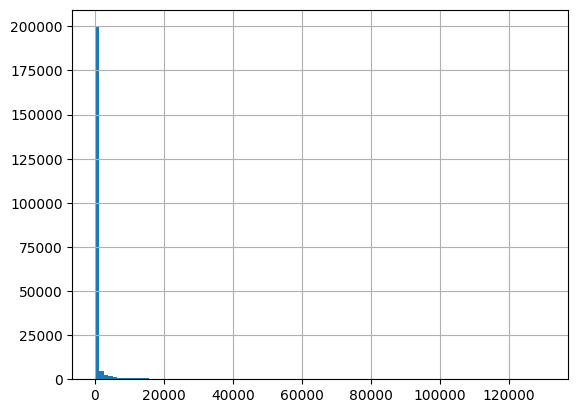

In [55]:
zipcode_sizes.hist(bins=100)

<AxesSubplot: >

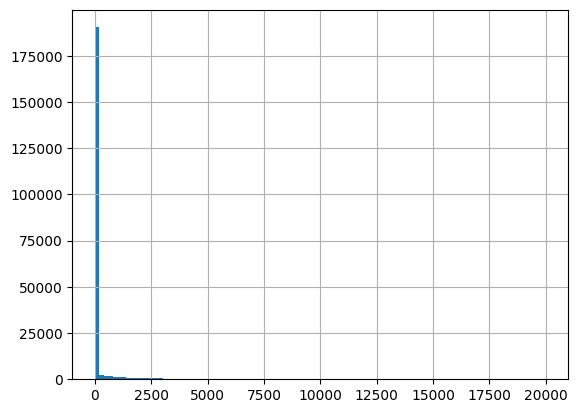

In [56]:
zipcode_sizes.loc[zipcode_sizes<20000].hist(bins=100)

<AxesSubplot: >

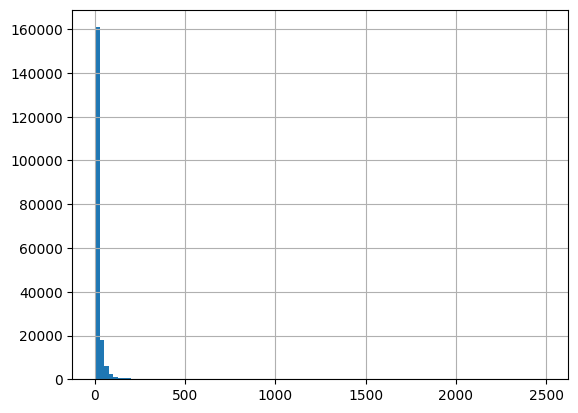

In [57]:
zipcode_sizes.loc[zipcode_sizes<2500].hist(bins=100)

<AxesSubplot: >

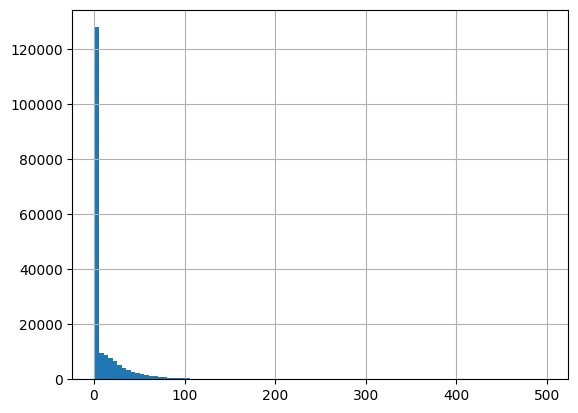

In [58]:
zipcode_sizes.loc[zipcode_sizes<500].hist(bins=100)

<AxesSubplot: >

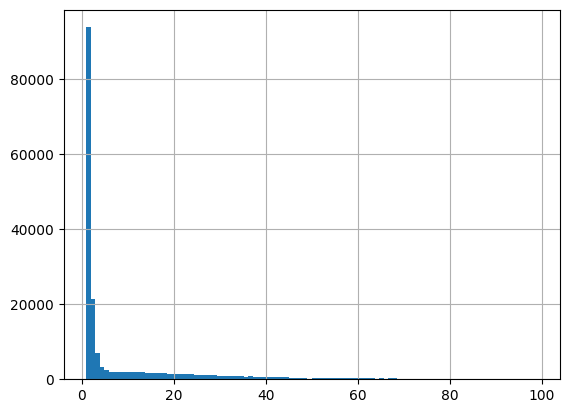

In [59]:
zipcode_sizes.loc[zipcode_sizes<100].hist(bins=100)

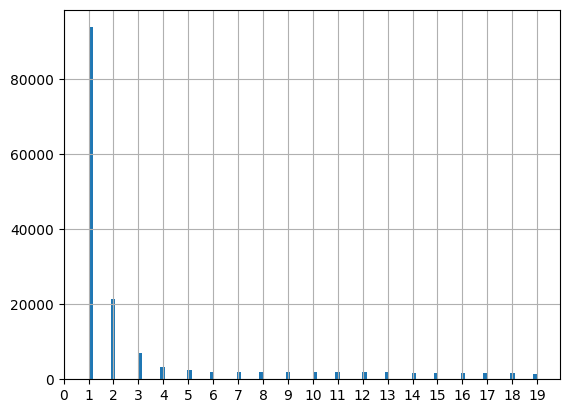

In [62]:
zipcode_sizes.loc[zipcode_sizes<20].hist(bins=100)
plt.xticks(range(20));

In [63]:
df_census.zipcode.nunique()

221149

In [66]:
221_149 / 41_704

5.3028246690964895

In [64]:
%%time
df_census.zipcode.map(type).value_counts()

CPU times: user 37 s, sys: 4.26 s, total: 41.2 s
Wall time: 41.1 s


<class 'str'>      328873134
<class 'float'>      3290716
Name: zipcode, dtype: int64

In [65]:
%%time
df_census.zipcode.str.len().value_counts()

CPU times: user 1min 41s, sys: 6.9 s, total: 1min 48s
Wall time: 1min 48s


5.0    328711144
6.0       157982
7.0         4008
Name: zipcode, dtype: int64

In [67]:
zipcode_sizes.value_counts()

1         93917
2         21479
3          7013
4          3191
5          2378
          ...  
14233         1
14236         1
14238         1
14239         1
130759        1
Name: simulant_id, Length: 15536, dtype: int64

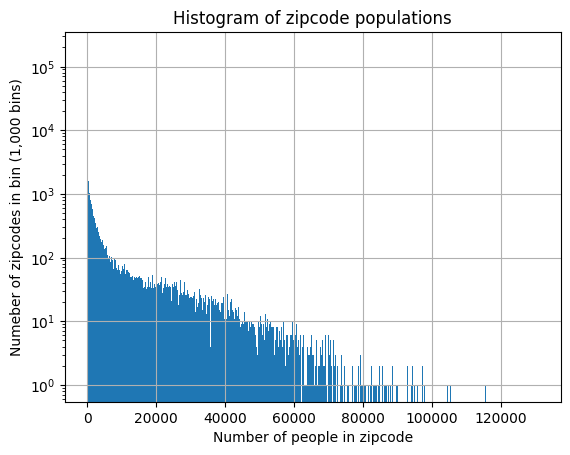

In [73]:
zipcode_sizes.hist(bins=1000)
plt.xlabel("Number of people in zipcode")
plt.ylabel("Numeber of zipcodes in bin (1,000 bins)")
plt.title("Histogram of zipcode populations")
plt.yscale('log')

In [75]:
config = get_configuration()
config.keys()

dict_keys(['decennial_census', 'american_communities_survey', 'current_population_survey', 'women_infants_and_children', 'social_security', 'taxes_w2_and_1099'])

In [76]:
config.decennial_census.column_noise.zipcode

missing_data:
    probability:
        baseline: 0.01
            source: None
zipcode_miswriting:
    probability:
        baseline: 0.01
            source: None
    first_two_digits_noise_level:
        baseline: 0.04
            source: None
    middle_digit_noise_level:
        baseline: 0.2
            source: None
    last_two_digits_noise_level:
        baseline: 0.36
            source: None
typographic:
    probability:
        baseline: 0.01
            source: None
    token_noise_level:
        baseline: 0.1
            source: None
    include_original_token_level:
        baseline: 0.1
            source: None

In [77]:
157982+4008

161990

In [78]:
vars(config)

{'_layers': ['baseline', 'default', 'user'],
 '_children': {'decennial_census': row_noise:
      omission:
          probability:
              default: 0.0145
                  source: None
              baseline: 0.0
                  source: None
  column_noise:
      first_name:
          missing_data:
              probability:
                  baseline: 0.01
                      source: None
          fake_name:
              probability:
                  baseline: 0.01
                      source: None
              token_noise_level:
                  baseline: 0.1
                      source: None
          typographic:
              probability:
                  baseline: 0.01
                      source: None
              token_noise_level:
                  baseline: 0.1
                      source: None
              include_original_token_level:
                  baseline: 0.1
                      source: None
      middle_initial:
          missing_data:
      